<a href="https://colab.research.google.com/github/darshil6p/NLP_ASSN_1/blob/master/NLP_ASSN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

data = pd.read_csv("housing.csv")
data=data.dropna()
data.head(10)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f28a3217f98>,
      dtype=object)

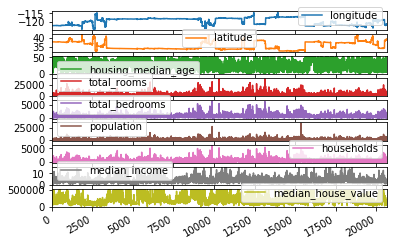

In [0]:
df = pd.DataFrame(data)
df.plot(subplots=True)

In [0]:
Y=data['median_house_value']
X=data.loc[:,'longitude':'median_income']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3, random_state=2003)
x_train_np=x_train.to_numpy()
y_train_np=y_train.to_numpy()

x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

[417600. 103600.  80600. ... 120200. 264400. 249000.]


In [0]:
import torch
from torch.nn import Conv1d
from torch.nn import MaxPool1d
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn.functional import relu

from torch.utils.data import DataLoader,TensorDataset
class CnnRegressor(torch.nn.Module):
    def __init__(self, batch_size, inputs, outputs):
        super(CnnRegressor, self).__init__()
        self.batch_size=batch_size
        self.inputs=inputs
        self.outputs=outputs

        self.input_layer=Conv1d(inputs, batch_size,1)
        self.max_pooling_layer=MaxPool1d(1)
        self.conv_layer=Conv1d(batch_size,128,1)
        self.flatten_layer=Flatten()
        self.linear_layer=Linear(128,64)
        self.output_layer= Linear(64,outputs)

    def feed(self,input):
        input=input.reshape((self.batch_size,self.inputs,1))

        output=relu(self.input_layer(input))
        output=self.max_pooling_layer(output)
        output=relu(self.conv_layer(output))
        output=self.flatten_layer(output)
        output=relu(self.linear_layer(output))
        output=self.output_layer(output)
        return output

In [0]:
from torch.optim import SGD
from torch.nn import L1Loss

!pip install pytorch-ignite


In [0]:
batch_size=32
model= CnnRegressor(batch_size, X.shape[1],1)

model.cuda()

In [0]:
def model_loss(model,dataset,train=False,optimizer=None):
  performance=L1Loss()
  score_metric= R2Score()

  avg_loss=0
  avg_score=0
  count=0
  for input,output in iter(dataset):
    predictions=model.feed(input)
    loss=performance(predictions,output)

    score_metric.update([predictions,output])
    score=score_metric.compute()

    if(train):
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    avg_loss+=loss.item()
    avg_score+=score
    count+=1
  return avg_loss/count,avg_score/count

In [0]:
epochs=1000
optimizer= SGD(model.parameters(),lr=1e-5)

inputs=torch.from_numpy(x_train_np).cuda().float()
outputs=torch.from_numpy(y_train_np.reshape(y_train_np.shape[0],1)).cuda().float()
tensor=TensorDataset(inputs,outputs)
loader=DataLoader(tensor,batch_size,shuffle=True,drop_last=True)

for epoch in range(epochs):
  avg_loss, avg_r2_score=model_loss(model,loader,train=True, optimizer=optimizer)
  print("Epoch"+str(epoch+1)+":\n\tLoss="+str(avg_loss)+"\n\tR^2 Score="+str(avg_r2_score))

inputs = torch.from_numpy(x_test_np).cuda().float()
outputs=torch.from_numpy(y_test_np.reshape(y_test_np.shape[0],1)).cuda().float()
tensor=TensorDataset(inputs,outputs)
loader=DataLoader(tensor,batch_size,shuffle=True,drop_last=True)

avg_loss,avg_r2_score=model_loss(model,loader)
print("The model's L1 Loss is: "+str(avg_loss))
print("The model's R^2 Loss is: "+str(avg_r2_score))

import pickle
with open ('model','wb') as f:
    pickle.dump(model,f)

Epoch1:
	Loss=90985.8952932315
	R^2 Score=-0.16021607866165896
Epoch2:
	Loss=88413.4460832399
	R^2 Score=-0.013804435653634668
Epoch3:
	Loss=89901.71443210483
	R^2 Score=-0.061034972467052716
Epoch4:
	Loss=86788.70207399104
	R^2 Score=-0.0187382423285978
Epoch5:
	Loss=88402.1088319787
	R^2 Score=-0.027291095862785077
Epoch6:
	Loss=85657.72182420123
	R^2 Score=0.0029134281285791656
Epoch7:
	Loss=85531.80011561098
	R^2 Score=-0.011325973642675364
Epoch8:
	Loss=86337.14779813621
	R^2 Score=0.03536547715557651
Epoch9:
	Loss=84731.85815758127
	R^2 Score=0.018705667902916178
Epoch10:
	Loss=85154.2877662556
	R^2 Score=0.04584410337136913
Epoch11:
	Loss=84298.0105188481
	R^2 Score=0.05584345154720908
Epoch12:
	Loss=83066.69061799327
	R^2 Score=0.08686067495442472
Epoch13:
	Loss=82924.01474915919
	R^2 Score=0.10578309559567041
Epoch14:
	Loss=83196.44634599215
	R^2 Score=0.10947548789445347
Epoch15:
	Loss=83130.23528587444
	R^2 Score=0.03444578364589622
Epoch16:
	Loss=82773.49189847254
	R^2 Scor

In [0]:
torch.save(model, 'model.pt')
model.eval()